In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from bs4 import BeautifulSoup  
import pandas as pd
import numpy as np
from scrapy import Selector
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
import time


In [8]:
## LIVE CODE ##

def review_scraper(link):

    # Initialize Selenium WebDriver
    driver = webdriver.Chrome()

    # Open the Yelp search page
    driver.get(link)

    review_names = []
    ratings = []
    reviews = []

    for i in range(10):
        try:
            # Wait for the reviews section to load
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "reviews"))
            )

            # Get the page source
            page_source = driver.page_source

            # Create a Scrapy selector
            sel = Selector(text=page_source)

            # Extract numerical ratings from each element
            for element in sel.css('div.yelp-emotion-19pbem2 > div > div > span > div'):
                full_rating = element.xpath('./@aria-label').get()
                numerical_rating = full_rating.split()[0]
                ratings.append(numerical_rating)

            # Extract text content from elements with the specified class
            review = [r.replace('<br />', '\n') for r in sel.css('p.comment__09f24__D0cxf.yelp-emotion-h9c2fl span').extract()]

            reviews.extend(review)

            # Locate the "more" link by CSS selector
            more_reviews = driver.find_element(By.CSS_SELECTOR, "a.next-link.navigation-button__09f24__m9qRz")

            # Click the "more" link
            more_reviews.click()

            # Wait for the next page to load
            WebDriverWait(driver, 10).until(
                EC.staleness_of(more_reviews)
            )
        except TimeoutException:
            print("Timed out waiting for page to load. Retrying...")
            time.sleep(5)  # Wait for a bit before retrying
        except Exception as e:
            print("An error occurred:", str(e))
            break  # Break out of the loop if an unexpected error occurs

    # Close the WebDriver
    driver.quit()

    return ratings, reviews


In [9]:
# Open the Yelp search page
ratings, reviews = review_scraper("https://www.yelp.com/biz/the-cuban-restaurant-and-bar-hoboken-2?osq=Restaurants")
len(ratings)
len(reviews)

Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...
Timed out waiting for page to load. Retrying...


92

92

In [22]:
## PRE-PROCESSION AND TABLE

# Preprocess the reviews to remove <br> tags and extra HTML
preprocessed_reviews = [review.replace('<br>', '') for review in reviews]
preprocessed_reviews = [review.replace('<span class=" raw__09f24__T4Ezm" lang="en">', '') for review in preprocessed_reviews]
rfinal = [review.replace('</span>', '') for review in preprocessed_reviews]

# Create a DataFrame
df = pd.DataFrame({'Rating': ratings, 'Review': rfinal})

# Display the DataFrame
print(df)

df['Rating'].value_counts()

   Rating                                             Review
0       4  The paella was delicious, my only comment is t...
1       4  Excellent food. Highly recommend the Mar Y Tie...
2       5  It had been a while since I've been back to Ho...
3       4  This Cuban restaurant is a surprise at the beg...
4       4  In addition to the paella which was a bit too ...
..    ...                                                ...
87      5  Amazing restaurant! I came here for my birthda...
88      1  Not good. We didn't like it. It was Dissapoint...
89      1  Took over 1.5 hours to get our food. Cute ambi...
90      5  Time and time again this place just nails it. ...
91      5  Sandra was our hostess and she was so nice Tha...

[92 rows x 2 columns]


5    42
4    22
1    13
3     9
2     6
Name: Rating, dtype: int64

In [23]:
import nltk, re, string
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
# numpy is the package for matrix cacluation
import numpy as np  
import pandas as pd

stop_words = stopwords.words('english')

# Step 1. get tokens of each document as list
def get_doc_tokens(doc):
    tokens=[token.strip() \
            for token in nltk.word_tokenize(doc.lower()) \
            if token.strip() not in stop_words and\
               token.strip() not in string.punctuation]
    
    # you can add bigrams, collocations, stemming, 
    # or lemmatization here
    
    token_count={token:tokens.count(token) for token in set(tokens)}
    return token_count

def tfidf(docs):
    # step 2. process all documents to get list of token list
    docs_tokens={idx:get_doc_tokens(doc) \
             for idx,doc in enumerate(docs)}

    # step 3. get document-term matrix
    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
    dtm = dtm.sort_index(axis = 0)
      
    # step 4. get normalized term frequency (tf) matrix        
    tf=dtm.values
    doc_len=tf.sum(axis=1, keepdims=True)
    tf=np.divide(tf, doc_len)
    
    # step 5. get idf
    df=np.where(tf>0,1,0)
    #idf=np.log(np.divide(len(docs), \
    #    np.sum(df, axis=0)))+1

    smoothed_idf=np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1    
    smoothed_tf_idf=tf*smoothed_idf
    
    return smoothed_tf_idf


In [24]:
tfidf_scores = tfidf(rfinal)

print("TF-IDF scores for all reviews:")
print(tfidf_scores)

TF-IDF scores for all reviews:
[[0.17003818 0.20154487 0.18846842 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.2338025  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.13827007 0.13827007 0.13827007]]


In [25]:
docs_tokens={idx:get_doc_tokens(doc) \
             for idx,doc in enumerate(rfinal)}
docs_tokens

{0: {'top': 1,
  'muscles': 1,
  'plato': 1,
  'white': 1,
  'classico': 1,
  'sangria': 1,
  'would': 1,
  'basically': 1,
  'el': 1,
  'delicious': 1,
  'pork': 1,
  'tender': 1,
  'pass': 1,
  'half': 1,
  'comment': 1,
  'pitcher': 1,
  'filled': 1,
  'juicy': 1,
  'paella': 1,
  'glasses': 1,
  'disintegrated': 1,
  'two': 1},
 1: {'skirt': 1,
  'ropa': 1,
  'food': 1,
  'steak': 2,
  'tierra': 1,
  'highly': 1,
  'braised': 1,
  'hangar': 1,
  'excellent': 1,
  'vieja': 1,
  'mar': 1,
  'recommend': 1},
 2: {'carlos': 2,
  'drinks': 1,
  'end': 1,
  'inside': 1,
  'fantastic': 2,
  'good': 2,
  'heard': 1,
  'outstanding': 1,
  'amp': 1,
  'eat': 2,
  'try': 1,
  'laughing': 1,
  'wife': 1,
  'stories': 1,
  'spicy': 1,
  'manager': 1,
  'hard': 1,
  'tostones': 1,
  'coming': 1,
  'apps': 1,
  'feeling': 1,
  'stairs': 1,
  'drink': 2,
  'thinly': 1,
  'impaled': 1,
  'lord': 1,
  'decided': 3,
  'say': 1,
  'thank': 1,
  'go': 1,
  'cucumber': 1,
  'cooled': 1,
  'since': 2,
  

In [26]:
# Create TF-IDF Matrix

from sklearn.feature_extraction.text import TfidfVectorizer

# initialize the TfidfVectorizer 

tfidf_vect = TfidfVectorizer(min_df = 2) 

# with stop words removed
tfidf_vect = TfidfVectorizer(stop_words="english") 

# generate tfidf matrix
dtm= tfidf_vect.fit_transform(df["Review"])

print("type of dtm:", type(dtm))
print("size of tfidf matrix:", dtm.shape)

type of dtm: <class 'scipy.sparse._csr.csr_matrix'>
size of tfidf matrix: (92, 1375)


In [27]:
print("total number of words:", len(tfidf_vect.vocabulary_))

print("type of vocabulary:", \
      type(tfidf_vect.vocabulary_))
print("index of word 'city' in vocabulary:", \
      tfidf_vect.vocabulary_['city'])

total number of words: 1375
type of vocabulary: <class 'dict'>
index of word 'city' in vocabulary: 219


In [28]:
voc_lookup = tfidf_vect.get_feature_names_out()

print("\nOriginal text: \n"+df["Review"][0])

print("\ntfidf weights: \n")

# first, covert the sparse matrix row to a dense array
doc0=dtm[0].toarray()[0]
print("Vectorized document shape: ", doc0.shape, "\n")

# get index of top 20 words
print("top words:")
top_words=(doc0.argsort())[::-1][0:20]
for i in top_words:
    print("{0}:\t{1:.3f}".format(voc_lookup[i], doc0[i]))
#[(voc_lookup[i], '%.3f'%doc0[i]) for i in top_words]


Original text: 
The paella was delicious, my only comment is that the muscles were basically disintegrated. The pork in the el Classico Plato was tender and juicy Would pass on the white sangria, a half pitcher filled two glasses up to the top.

tfidf weights: 

Vectorized document shape:  (1375,) 

top words:
filled:	0.272
comment:	0.272
disintegrated:	0.272
juicy:	0.272
pitcher:	0.249
glasses:	0.249
muscles:	0.249
half:	0.233
classico:	0.233
plato:	0.233
pass:	0.233
tender:	0.220
basically:	0.220
pork:	0.210
white:	0.210
el:	0.201
paella:	0.176
sangria:	0.171
delicious:	0.122
fish:	0.000


In [57]:
#Classification using train/test split

# use MultinomialNB and SVM algorithms
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

# import method for split train/test data set
from sklearn.model_selection import train_test_split

# import method to calculate metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

# split dataset into train (70%) and test sets (30%)
X_train, X_test, y_train, y_test = train_test_split(\
                dtm, df["Rating"], test_size=0.3,\
                    random_state=0)

class_weights = {'1': 8, '2': 15, '3': 2, '4': 1.3, '5': .5}

total_samples = len(y_train)
class_counts = {label: y_train.value_counts()[label] for label in y_train.unique()}
prior_probs = {label: count / total_samples for label, count in class_counts.items()}
adjusted_priors = {label: prior_probs[label] * class_weights[label] for label in class_weights.keys()}


# train a multinomial naive Bayes model using the testing data
clf_nb = MultinomialNB(alpha=0, class_prior=list(adjusted_priors.values()), fit_prior=False).fit(X_train, y_train)

# predict the news group for the test dataset
predicted_nb=clf_nb.predict(X_test)

# or you can train a linear SVM model
clf_svm = svm.LinearSVC(class_weight=class_weights).fit(X_train, y_train)
predicted_svm=clf_svm.predict(X_test)


# check a few samples
print('Naive Bayes: ', predicted_nb[5:10])
print('\nSVM: ',predicted_svm[5:10])
y_test[5:10]

Naive Bayes:  ['4' '5' '5' '1' '5']

SVM:  ['5' '5' '4' '5' '5']


C:\Users\huntd\Anaconda\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


24    5
60    5
76    4
80    1
68    4
Name: Rating, dtype: object

In [58]:
# Performance evaluation: 
# precision, recall, f1-score

# get the list of unique labels
labels = sorted(set(y_test))

# Performance for NB 
# Support is the number of occurrences of each label

precision_nb, recall_nb, fscore_nb, support=\
     precision_recall_fscore_support(\
     y_test, predicted_nb, labels=labels)

print('Naive Bayes Performance: ')
print("labels: ", labels)
print("precision: ", precision_nb)
print("recall: ", recall_nb)
print("f-score: ", fscore_nb)
print("support: ", support)

# another way to get all performance metrics
print(classification_report\
      (y_test, predicted_nb, target_names=labels))

# Performance for SVM 
# Support is the number of occurrences of each label

precision_svm, recall_svm, fscore_svm, support=\
     precision_recall_fscore_support(\
     y_test, predicted_svm, labels=labels)
print('SVM Performance: ')
print("labels: ", labels)
print("precision: ", precision_svm)
print("recall: ", recall_svm)
print("f-score: ", fscore_svm)
print("support: ", support)

# another way to get all performance metrics
print(classification_report\
      (y_test, predicted_svm, target_names=labels))

Naive Bayes Performance: 
labels:  ['1', '2', '3', '4', '5']
precision:  [0.25       0.         1.         0.         0.44444444]
recall:  [0.25       0.         0.33333333 0.         0.8       ]
f-score:  [0.25       0.         0.5        0.         0.57142857]
support:  [ 4  4  3  7 10]
              precision    recall  f1-score   support

           1       0.25      0.25      0.25         4
           2       0.00      0.00      0.00         4
           3       1.00      0.33      0.50         3
           4       0.00      0.00      0.00         7
           5       0.44      0.80      0.57        10

    accuracy                           0.36        28
   macro avg       0.34      0.28      0.26        28
weighted avg       0.30      0.36      0.29        28

SVM Performance: 
labels:  ['1', '2', '3', '4', '5']
precision:  [0.         0.         0.         0.2        0.39130435]
recall:  [0.         0.         0.         0.14285714 0.9       ]
f-score:  [0.         0.         

C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\

In [59]:
### AUC Analysis Naive Bayes

from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np

# We need to get probabilities as predictions
predict_nb=clf_nb.predict_proba(X_test)

# for linear SVC, you can use decision_function instead of predict_proba
# predict_prob is not available unless you enable it. Check sklearn documentation
#predict_p=clf.decision_function(X_test)
auc_scores_nb = []
for label in labels:
    # Convert labels to binary (1 for the current class, 0 for others)
    binary_y_nb = np.where(y_test == label, 1, 0)
    # Get predicted probabilities for the current class
    probabilities_nb = predict_nb[:, labels.index(label)]
    # Compute fpr/tpr by different thresholds
    fpr_nb, tpr_nb, thresholds_nb = roc_curve(binary_y_nb, probabilities_nb, pos_label=1)
    # Compute AUC for the current class
    auc_score_nb = auc(fpr_nb, tpr_nb)
    auc_scores_nb.append(auc_score_nb)

# Print AUC for each class
for label, auc_score_nb in zip(labels, auc_scores_nb):
    print("AUC for class {}: {:.2%}".format(label, auc_score_nb))

AUC for class 1: 71.88%
AUC for class 2: 71.88%
AUC for class 3: 68.00%
AUC for class 4: 48.30%
AUC for class 5: 71.11%


In [60]:
## AUC SVM

# We need to get probabilities as predictions
# Get decision function scores for each class
decision_function_scores = clf_svm.decision_function(X_test)

# Compute AUC for each class
auc_scores_svm = []
for label in labels:
    # Convert labels to binary (1 for the current class, 0 for others)
    binary_y_svm = np.where(y_test == label, 1, 0)
    # Get decision function scores for the current class
    scores_svm = decision_function_scores[:, labels.index(label)]
    # Compute fpr/tpr by different thresholds
    fpr_svm, tpr_svm, thresholds_svm = roc_curve(binary_y_svm, scores_svm, pos_label=1)
    # Compute AUC for the current class
    auc_score_svm = auc(fpr_svm, tpr_svm)
    auc_scores_svm.append(auc_score_svm)

# Print AUC for each class
for label, auc_score_svm in zip(labels, auc_scores_svm):
    print("SVM - AUC for class {}: {:.2%}".format(label, auc_score_svm))

SVM - AUC for class 1: 56.25%
SVM - AUC for class 2: 58.33%
SVM - AUC for class 3: 76.00%
SVM - AUC for class 4: 67.35%
SVM - AUC for class 5: 80.56%


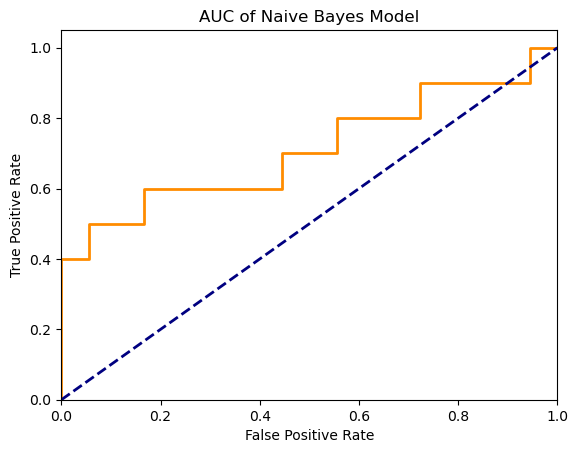

In [61]:
## Navie Bayes Model

from matplotlib import pyplot as plt
plt.figure();
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Naive Bayes Model');
plt.show();

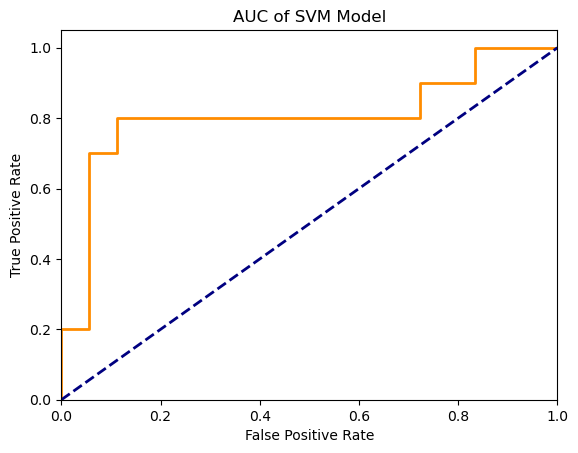

In [62]:
## SVM Model

from matplotlib import pyplot as plt
plt.figure();
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of SVM Model');
plt.show();

In [63]:
# Run 5-fold cross validation
# to show the generalizability of the model

# import cross validation method
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

metrics = ['precision_macro', 'recall_macro', \
           "f1_macro"]

clf_nb_cv = MultinomialNB()
#clf = MultinomialNB(alpha=0.5)

cv = cross_validate(clf_nb_cv, dtm, df["Rating"], \
                    scoring=metrics, cv=5, \
                    return_train_score=True)
print("Test data set average precision:")
print(cv['test_precision_macro'])
print("\nTest data set average recall:")
print(cv['test_recall_macro'])
print("\nTest data set average f1 score:")
print(cv['test_f1_macro'])

# To see the performance of training data set use 
# cv['train_xx_macro']
print("\nTraining data average f1 score:")
print(cv['train_f1_macro'])

# The metrics are quite stable across folds.
# The performance gap between training and test sets is small
# This indicates the model has good generalizability

Test data set average precision:
[0.08421053 0.08421053 0.1        0.1        0.08888889]

Test data set average recall:
[0.2 0.2 0.2 0.2 0.2]

Test data set average f1 score:
[0.11851852 0.11851852 0.13333333 0.13333333 0.12307692]

Training data average f1 score:
[0.22424242 0.23900129 0.244      0.26802721 0.27070707]


C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetri

In [56]:
# Run 5-fold cross validation
# to show the generalizability of the model

# import cross validation method
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB

metrics = ['precision_macro', 'recall_macro', \
           "f1_macro"]

clf_svm_cv = svm.LinearSVC()
#clf = MultinomialNB(alpha=0.5)

cv = cross_validate(clf_svm_cv, dtm, df["Rating"], \
                    scoring=metrics, cv=5, \
                    return_train_score=True)
print("Test data set average precision:")
print(cv['test_precision_macro'])
print("\nTest data set average recall:")
print(cv['test_recall_macro'])
print("\nTest data set average f1 score:")
print(cv['test_f1_macro'])

# To see the performance of training data set use 
# cv['train_xx_macro']
print("\nTraining data average f1 score:")
print(cv['train_f1_macro'])



Test data set average precision:
[0.09411765 0.0875     0.12857143 0.18666667 0.16      ]

Test data set average recall:
[0.2   0.175 0.2   0.25  0.225]

Test data set average f1 score:
[0.128      0.11666667 0.15652174 0.20714286 0.17888199]

Training data average f1 score:
[1. 1. 1. 1. 1.]


C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\huntd\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetri

In [64]:
# Grid search to tune hyperparameters

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# build a pipeline which does two steps all together:
# (1) generate tfidf, and (2) train classifier
# each step is named, i.e. "tfidf", "clf"

text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', svm.LinearSVC())
                   ])

# set the range of parameters to be tuned
# each parameter is defined as 
# <step name>__<parameter name in step>
# e.g. min_df is a parameter of TfidfVectorizer()
# "tfidf" is the name for TfidfVectorizer()
# therefore, 'tfidf__min_df' is the parameter in grid search

parameters = {'tfidf__min_df':[1,3],
              'tfidf__stop_words':[None,"english"],
              'clf__C': [0.5,1.0,5.0],
}

# the metric used to select the best parameters
metric =  "f1_macro"

# GridSearch also uses cross validation
gs_clf = GridSearchCV\
(text_clf, param_grid=parameters, \
 scoring=metric, cv=5)

# due to data volume and large parameter combinations
# it may take long time to search for optimal parameter combination
# you can use a subset of data to test
gs_clf = gs_clf.fit(df["Review"], df["Rating"])
gs_clf

for param_name in gs_clf.best_params_:
    print("{0}:\t{1}".format(param_name,\
                                 gs_clf.best_params_[param_name]))

print("best f1 score: {:.3f}".format(gs_clf.best_score_))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LinearSVC())]),
             param_grid={'clf__C': [0.5, 1.0, 5.0], 'tfidf__min_df': [1, 3],
                         'tfidf__stop_words': [None, 'english']},
             scoring='f1_macro')

clf__C:	5.0
tfidf__min_df:	3
tfidf__stop_words:	None
best f1 score: 0.351


In [65]:
## Predict new documents

Review_new = ["I have to start off by saying that the only good part about this restaurant is the drinks. The service was ok but the prices for the food were too expensive for the amount they put on your plate. Wasn't worth the money. To top it off we felt rushed out of the restaurant couldnt eat the food on your plate because they kept asking if I was done knowing that I was still eating. The restaurant closed at 10pm and started shutting off the lights at 9:30pm. We literally felt kicked out. Will not go there again."]

# generate tfidf for new documents
# note we use "transform" not "fit_transform"
# transform creates tfidf vectors based on the
# vocabulary established by "fit_transform" in Exercise 3.2.
X_new_tfidf = tfidf_vect.transform(Review_new)

print("new sample tf_idf size:", X_new_tfidf.shape)

# prediction
print("Naive Bayes Prediction: ",clf_nb.predict(X_new_tfidf))
print("SVM Prediction: ",clf_svm.predict(X_new_tfidf))
print("Actual: 2")


Review_2 = ["This place is the worst representation of Cuban food. We ordered delivery and got the paella for $29, shredded beef for $27, churros for $10. The Paella was bland and there was little to no sea food. Also the Portions are extremely small for the price. We got 1 small cup of rice for the shredded beef and the container was mostly liquid instead of meat. Huge disappointment. The Churros were soggy and only had four small pieces. Overpriced bland food. They should really work on their portion size. Literally ripping people off. I will never order from this place again and will not recommend to anyone."]

# generate tfidf for new documents
# note we use "transform" not "fit_transform"
# transform creates tfidf vectors based on the
# vocabulary established by "fit_transform" in Exercise 3.2.
X_new_tfidf = tfidf_vect.transform(Review_2)

print("new sample tf_idf size:", X_new_tfidf.shape)

# prediction
print("Naive Bayes Prediction: ",clf_nb.predict(X_new_tfidf))
print("SVM Prediction: ",clf_svm.predict(X_new_tfidf))
print("Actual: 1")


new sample tf_idf size: (1, 1375)
Naive Bayes Prediction:  ['3']
SVM Prediction:  ['3']
Actual: 2
new sample tf_idf size: (1, 1375)
Naive Bayes Prediction:  ['5']
SVM Prediction:  ['5']
Actual: 1


# We pursued options for extracting links on the restaurant list page. We were able to extract the links. However, when we fed those links into our review scraper, we kept running into timeout errors.



In [66]:
from urllib.parse import urlparse, urljoin

def extract_links(list_page):
    driver = webdriver.Chrome()
    driver.get(list_page)

    # Wait for the search results container to be present
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "main-content")))

    # Get the page source
    page_source = driver.page_source

    # Create a Scrapy selector
    sel = Selector(text=page_source)

    link = sel.css('div.businessName__09f24__HG_pC.yelp-emotion-ohs7lg > div > h3 > a::attr(href)').extract()

    filtered_links = [link for link in link if "ad_business" not in link]

    base_url = "https://www.yelp.com"
    filtered_links = [link if link.startswith("http") else urljoin(base_url, link) for link in filtered_links]

    return filtered_links

    driver.quit()


In [67]:
filtered_links = extract_links('https://www.yelp.com/search?find_desc=Restaurants&find_loc=Hoboken%2C+NJ&sortby=review_count')

for link in filtered_links:
    print(link)

https://www.yelp.com/biz/the-cuban-restaurant-and-bar-hoboken-2?osq=Restaurants
https://www.yelp.com/biz/la-isla-restaurant-hoboken?osq=Restaurants
https://www.yelp.com/biz/anthony-davids-hoboken?osq=Restaurants
https://www.yelp.com/biz/mamouns-falafel-hoboken-3?osq=Restaurants
https://www.yelp.com/biz/turning-point-of-hoboken-hoboken?osq=Restaurants
https://www.yelp.com/biz/karma-kafe-hoboken?osq=Restaurants
https://www.yelp.com/biz/benny-tudinos-pizzeria-hoboken?osq=Restaurants
https://www.yelp.com/biz/antique-bar-and-bakery-hoboken-2?osq=Restaurants
https://www.yelp.com/biz/tony-boloneys-hoboken-hoboken?osq=Restaurants
https://www.yelp.com/biz/fiores-house-of-quality-hoboken-2?osq=Restaurants


In [68]:
# DOES NOT WORK

# for link in filtered_links:
#    ratings, reviews = review_scrape(link)